## 1. Preparing Alpha Factors and Features

In this part, I ingest the data and engineer market factors from the data. Alot of breakdowns for the multiindex and formatting. 

## Imports & Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR, SAR

In [4]:
MONTH = 21
YEAR = 12 * MONTH

In [5]:
START = '2012-01-01'
END = '2019-12-31' 

In [6]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [7]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]

In [8]:
T = [1, 5, 10, 21, 42, 63]

## Loading Stock Prices & Preparing Data, Excel Imports

In [9]:
# Ingest the high, open, low, close and volume data
bdata = pd.read_excel('C:/Users/Eric/Desktop/Model Creation/Gradient Boosters/data/Book4.xlsx','Sheet4',header=None,engine='openpyxl')
bdata.head()

,0,1,2,3,4,5,6,7,8,9,...,10186,10187,10188,10189,10190,10191,10192,10193,10194,10195
0,NaN,AAN UN Equity,NaN,NaN,NaN,NaN,AAON UW Equity,NaN,NaN,NaN,...,ZY UW Equity,NaN,NaN,NaN,NaN,ZYXI UW Equity,NaN,NaN,NaN,NaN
1,Dates,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,...,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME
2,2021-12-23 00:00:00,24.49,24.83,24.83,24.49,46526,78.57,78.9,79.67,78.46,...,7.61,7.31,7.66,7.16,213700,10.96,10.65,11.33,10.52,102349
3,2021-12-22 00:00:00,24.53,24.2,24.54,23.91,55663,78.6,78,78.89,77.9,...,7.31,7.43,7.59,7.08,262401,10.57,10.27,10.84,10.27,99515
4,2021-12-21 00:00:00,24.22,23.84,24.47,23.84,79388,77.91,77.54,78.37,77.01,...,7.41,7.16,7.44,7.09,655026,10.16,9.89,10.3,9.84,99037


In [10]:
# Ingest ticker metadata
bmeta = pd.read_excel('C:/Users/Eric/Desktop/Model Creation/Gradient Boosters/data/Book4.xlsx','Sheet1',header=0,engine='openpyxl')

## Adjusting the formatting from excel for the Gradient Boosting algorithims used

Creating the MultiIndex

In [11]:
tickdata = bdata.iloc[0].dropna()
tickdata = tickdata.str.split().str.get(0) # Isolate the ticker name
tickdata = tickdata.str.replace(' ', '') # Formating issue with import data
print(tickdata)

1         AAN
6        AAON
11        AAT
16       AAWW
21       ABCB
         ... 
10171     ZUO
10176    ZVIA
10181     ZWS
10186      ZY
10191    ZYXI
Name: 0, Length: 2039, dtype: object


In [12]:
features = bdata.iloc[1,1:6]
print(features)

1      PX_LAST
2      PX_OPEN
3      PX_HIGH
4       PX_LOW
5    PX_VOLUME
Name: 1, dtype: object


In [14]:
multi = pd.MultiIndex.from_product([tickdata,features],names=['symbol',''])
print(multi)

MultiIndex([( 'AAN',   'PX_LAST'),
            ( 'AAN',   'PX_OPEN'),
            ( 'AAN',   'PX_HIGH'),
            ( 'AAN',    'PX_LOW'),
            ( 'AAN', 'PX_VOLUME'),
            ('AAON',   'PX_LAST'),
            ('AAON',   'PX_OPEN'),
            ('AAON',   'PX_HIGH'),
            ('AAON',    'PX_LOW'),
            ('AAON', 'PX_VOLUME'),
            ...
            (  'ZY',   'PX_LAST'),
            (  'ZY',   'PX_OPEN'),
            (  'ZY',   'PX_HIGH'),
            (  'ZY',    'PX_LOW'),
            (  'ZY', 'PX_VOLUME'),
            ('ZYXI',   'PX_LAST'),
            ('ZYXI',   'PX_OPEN'),
            ('ZYXI',   'PX_HIGH'),
            ('ZYXI',    'PX_LOW'),
            ('ZYXI', 'PX_VOLUME')],
           names=['symbol', ''], length=10195)


Metadata preparation

In [15]:
metadata=bmeta
metadata['symbol']=metadata.symbol.str.split().str.get(0) # To match formatting of other dataframe
metadata = metadata.loc[:,['symbol','GICS_SECTOR_NAME','CUR_MKT_CAP']].rename(columns={'GICS_SECTOR_NAME':'sector','CUR_MKT_CAP':'marketcap'}) #simplify column name
metadata.set_index('symbol',inplace=True)

Ticker data prepation

In [16]:
prices = bdata.transpose()
prices.iloc[0,1]='NaN' # Ease of formating for later
prices = prices.iloc[0:,2:]
header = prices.iloc[0]

prices = prices.iloc[1:]
prices.rename(columns = header, inplace = True)
prices.set_index(multi, inplace=True)

prices = prices.stack().unstack(level=1)
prices.index = prices.index.set_levels([prices.index.levels[0], pd.to_datetime(prices.index.levels[1],format='%y/%m/%d')])
prices.index.names = ['symbol', 'date']
prices.rename(columns=lambda x: x.replace('PX_', ''),inplace=True)
prices.rename(columns={'HIGH':'high','LAST':'close','LOW':'low','OPEN':'open','VOLUME':'volume'},inplace=True)
prices.volume /= 1e3 # make vol figures a bit smaller
prices.sort_index(inplace=True)
prices = prices.astype('float64')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4337507 entries, ('AAN', Timestamp('2020-11-25 00:00:00')) to ('ZYXI', Timestamp('2021-12-23 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   high    float64
 1   close   float64
 2   low     float64
 3   open    float64
 4   volume  float64
dtypes: float64(5)
memory usage: 182.1+ MB


In [17]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2039 entries, AAN to ZYXI
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sector     2039 non-null   object 
 1   marketcap  2039 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.8+ KB


## Remove stocks with insufficient observations

We require at least 7 years of data; we simplify and select using both in- and out-of-sample period

In [ ]:
min_obs = 7 * YEAR
nobs = prices.groupby(level='symbol').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

### Align price and meta data

In [ ]:
metadata = metadata[~metadata.index.duplicated() & metadata.sector.notnull()]
metadata.sector = metadata.sector.str.lower().str.replace(' ', '_')

In [ ]:
shared = (prices.index.get_level_values('symbol').unique()
          .intersection(metadata.index))
metadata = metadata.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

Again, we simplify and use the entire sample period, not just the training period, to select our universe. 

In [22]:
universe = metadata.marketcap.nlargest(1000).index # simplify amount of tickers for computation speed
prices = prices.loc[idx[universe, :], :]
metadata = metadata.loc[universe]

In [23]:
metadata.sector.value_counts()

financials                200
industrials               165
health_care               145
consumer_discretionary    123
information_technology    114
real_estate                68
materials                  50
energy                     45
consumer_staples           35
communication_services     32
utilities                  23
Name: sector, dtype: int64

In [24]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3025636 entries, ('AMC', Timestamp('2013-12-18 00:00:00')) to ('HAYN', Timestamp('2021-12-23 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   high    3025632 non-null  float64
 1   close   3025632 non-null  float64
 2   low     3025632 non-null  float64
 3   open    3025632 non-null  float64
 4   volume  3025636 non-null  float64
dtypes: float64(5)
memory usage: 127.1+ MB


In [25]:
prices.to_hdf('data/prices', 'prices') # for later ingesting

### Rank assets by Rolling Average Dollar Volume

#### Compute dollar volume

In [76]:
prices['dollar_vol'] = prices[['close', 'volume']].prod(1).div(1e3)

#### 21-day moving average

In [77]:
# compute dollar volume to determine universe
dollar_vol_ma = (prices
                 .dollar_vol
                 .unstack('symbol')
                 .rolling(window=21, min_periods=1) # 1 trading month
                 .mean())

#### Rank stocks by moving average

In [78]:
prices['dollar_vol_rank'] = (dollar_vol_ma
                            .rank(axis=1, ascending=False)
                            .stack('symbol')
                            .swaplevel())

In [79]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3025636 entries, ('AMC', Timestamp('2013-12-18 00:00:00')) to ('HAYN', Timestamp('2021-12-23 00:00:00'))
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   high             3025632 non-null  float64
 1   close            3025632 non-null  float64
 2   low              3025632 non-null  float64
 3   open             3025632 non-null  float64
 4   volume           3025636 non-null  float64
 5   dollar_vol       3025636 non-null  float64
 6   dollar_vol_rank  3025636 non-null  float64
dtypes: float64(7)
memory usage: 173.2+ MB


## Add some Basic Factors

See [appendix](../24_alpha_factor_library) for details on the below indicators.

### Compute the Relative Strength Index

In [80]:
prices['rsi'] = prices.groupby(level='symbol').close.apply(RSI)

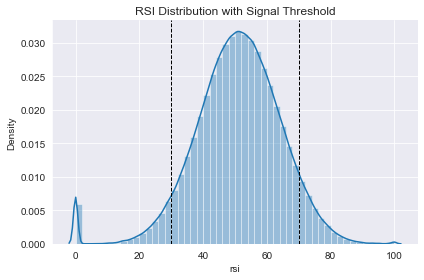

In [81]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

### Compute Bollinger Bands

In [82]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [83]:
prices = (prices.join(prices
                      .groupby(level='symbol')
                      .close
                      .apply(compute_bb)))

In [84]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

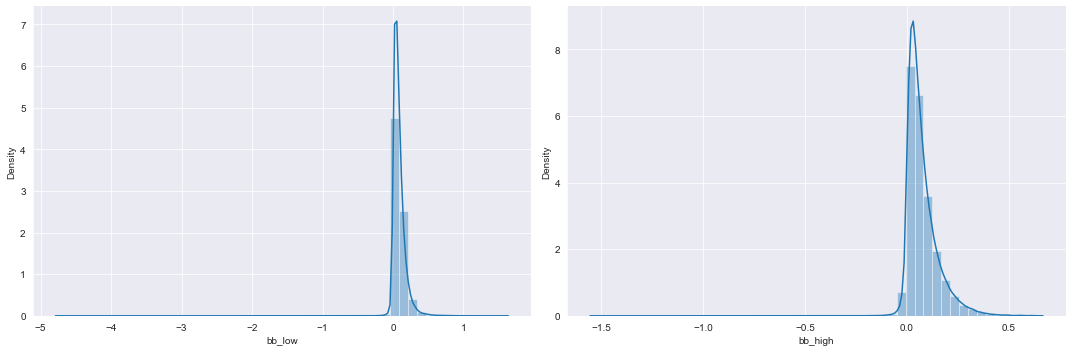

In [85]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();

In [86]:
def compute_SAR(stock_data):
    sar = SAR(stock_data.high, stock_data.low, acceleration=0.02, maximum=0.2)
    return pd.DataFrame({'SAR':sar})

In [87]:
prices['SAR'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_SAR))

### Compute Average True Range

In [89]:
prices['NATR'] = prices.groupby(level='symbol', 
                                group_keys=False).apply(lambda x: 
                                                        talib.NATR(x.high, x.low, x.close))

In [90]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [91]:
prices['ATR'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_atr))

### Compute Moving Average Convergence/Divergence

In [92]:
prices['PPO'] = prices.groupby(level='symbol').close.apply(talib.PPO)

In [93]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [94]:
prices['MACD'] = (prices
                  .groupby('symbol', group_keys=False)
                  .close
                  .apply(compute_macd))

### Combine Price and Meta Data

In [95]:
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

## Compute Returns

### Historical Returns

In [96]:
by_sym = prices.groupby(level='symbol').close
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

### Daily historical return deciles

In [97]:
for t in T:
    prices[f'r{t:02}dec'] = (prices[f'r{t:02}']
                             .groupby(level='date')
                             .apply(lambda x: pd.qcut(x, 
                                                      q=10, 
                                                      labels=False, 
                                                      duplicates='drop')))

### Daily sector return deciles

In [98]:
for t in T:
    prices[f'r{t:02}q_sector'] = (prices
                                  .groupby(['date', 'sector'])[f'r{t:02}']
                                  .transform(lambda x: pd.qcut(x, 
                                                               q=5, 
                                                               labels=False, 
                                                               duplicates='drop')))

### Compute Forward Returns

In [99]:
for t in [1, 5, 21]:
    prices[f'r{t:02}_fwd'] = prices.groupby(level='symbol')[f'r{t:02}'].shift(-t)

## Remove outliers

In [100]:
prices[[f'r{t:02}' for t in T]].describe()

,r01,r05,r10,r21,r42,r63
count,3.024632e+06,3.020632e+06,3.015632e+06,3.004632e+06,2.983632e+06,2.962632e+06
mean,7.738624e-04,3.745831e-03,7.329746e-03,1.542132e-02,3.059214e-02,4.543699e-02
std,3.362880e-02,7.437667e-02,1.035465e-01,1.507662e-01,2.255153e-01,2.924734e-01
min,-8.666667e-01,-9.152941e-01,-9.497908e-01,-9.535484e-01,-9.810284e-01,-9.805710e-01
25%,-1.076182e-02,-2.444349e-02,-3.399584e-02,-4.795964e-02,-6.379453e-02,-7.566419e-02
50%,0.000000e+00,1.364256e-03,3.250975e-03,7.801563e-03,1.497631e-02,2.197802e-02
75%,1.161414e-02,2.905812e-02,4.370608e-02,6.856088e-02,1.042434e-01,1.345152e-01
max,2.223529e+01,2.264706e+01,2.245588e+01,2.069128e+01,5.338596e+01,5.214286e+01


Remove daily returns above 100 percent as these are more likely to represent data errors. Apply more careful exploratory and historical analysis in general.

In [101]:
outliers = prices[prices.r01 > 1.5].index.get_level_values('symbol').unique()
print(outliers)

Index(['AMC', 'CAR', 'GBCI', 'NOVT', 'GTLS', 'CELH', 'SKY', 'ITCI', 'CNMD',
       'HOMB', 'MARA', 'ACAD', 'INSM', 'HLIO', 'RAMP', 'DDD', 'CCXI', 'FCEL',
       'STFC', 'MFA', 'ARGO', 'SAVA', 'SRNE', 'SUPN', 'RCKT', 'AMRX', 'MDGL',
       'GES', 'AVID', 'ERII', 'LPI', 'AXL', 'MGNX', 'OCGN', 'HRTX', 'GEVO',
       'MVIS', 'ZGNX', 'GCI', 'MMAT', 'LEU', 'IIIN', 'CPRX', 'AFMD', 'MGI',
       'LXRX', 'SIGA', 'ABUS', 'EGLE', 'INVE', 'ICPT'],
      dtype='object', name='symbol')

In [102]:
prices = prices.drop(outliers, level='symbol')

## Create time and sector dummy variables

In [103]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday

## Store Model Data

In [104]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2879460 entries, ('SYNA', Timestamp('2009-06-22 00:00:00')) to ('HAYN', Timestamp('2021-12-23 00:00:00'))
Data columns (total 40 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   high             2879456 non-null  float64
 1   close            2879456 non-null  float64
 2   low              2879456 non-null  float64
 3   open             2879456 non-null  float64
 4   volume           2879460 non-null  float64
 5   dollar_vol       2879460 non-null  float64
 6   dollar_vol_rank  2879460 non-null  float64
 7   rsi              2866170 non-null  float64
 8   bb_high          2861425 non-null  float64
 9   bb_low           2861410 non-null  float64
 10  SAR              2878507 non-null  float64
 11  NATR             2866170 non-null  float64
 12  ATR              2866170 non-null  float64
 13  PPO              2855731 non-null  float64
 14  MACD             2848139 non-null  flo

In [105]:
prices.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).to_hdf('data.h5', 'model_data')